In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display, Markdown
# mpl.rc('text', usetex=True)
mpl.rc('font', family='Arial')
mpl.rc('font',size = 8)
mpl.rc('mathtext',fontset = 'stix')

mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
mpl.rc('axes', labelsize=10)
mpl.rc('axes', labelpad=1.5)
mpl.rc('axes', titlesize=12)
mpl.rc('axes', linewidth=0.5)
mpl.rc('figure', figsize=(3.55/2.54, 2.8/2.54))
mpl.rc('figure', dpi=400)
mpl.rc('legend',frameon = False)
mpl.rc('savefig',pad_inches = 0.01)

In [2]:
def FR(GT_coefs, PRE_coefs):
    for i in range(len(GT_coefs[0])):
        GT_coef = GT_coefs[:,i]
        if ((GT_coef != 0) == (PRE_coefs != 0)).all():
            return 1
    return 0

def sMAPE(GT_coefs, PRE_coefs):
    diffs = []
    for i in range(len(GT_coefs[0])):
        GT_coef = GT_coefs[:,i]
        mape = 0
        n = len(GT_coefs)
        for j in range(len(GT_coefs)):
            if(np.abs(GT_coef[j])+np.abs(PRE_coefs[j]) == 0):
                continue
            else:
                s = np.abs(GT_coef[j] - PRE_coefs[j])/(np.abs(GT_coef[j])+np.abs(PRE_coefs[j]))
                mape+=s
        mape = mape/n
        diffs.append(mape)
    return np.min(diffs)

In [3]:
noises = range(20,65,5)
es = np.logspace(-1,-4,10)
models = ["our","STLSQ","SR3","essemble"]
dynamics = "vanderpol"
num_trails = 100

In [4]:
es

array([0.1       , 0.04641589, 0.02154435, 0.01      , 0.00464159,
       0.00215443, 0.001     , 0.00046416, 0.00021544, 0.0001    ])

In [5]:

Coef_GT = np.array(pd.read_csv('./Data/GroundTruth/%s_coefficient.csv'%dynamics,index_col = 0))
result_smape = np.zeros([len(models),len(noises),len(es)])
result_fr = np.zeros([len(models),len(noises),len(es)])
for m in range(len(models)):
    model = models[m]
    Coef_GT = np.array(pd.read_csv('./Data/GroundTruth/%s_coefficient.csv'%dynamics,index_col = 0))
    for i in range(len(noises)):
        for j in range(len(es)):
            data = pd.read_csv("./Result/Coef/%s_%s_%ddB_%d_coefpredict.csv"%(model,dynamics,noises[i],j))
            sMAPEs = []
            FRs = []
            Coef_now = np.zeros_like(Coef_GT)
            Coef_now[0,:] = Coef_GT[0,:]
            Coef_now[1:,:] = Coef_GT[1:,:]*es[j]
            for n in range(num_trails):
                coef_pre = np.array(data.iloc[n])[1:]
                sMAPEs.append(sMAPE(Coef_now,coef_pre))
                FRs.append(FR(Coef_now,coef_pre))
            result_smape[m,i,j] = np.mean(sMAPEs)
            result_fr[m,i,j] = np.mean(FRs)
        

In [6]:
from matplotlib.colors import LinearSegmentedColormap

bounds = [0,0.5,1]

colors = ["#8CA5EA","#FFFFFF","#E3738B"]

cmap = LinearSegmentedColormap.from_list('mymap', list(zip(bounds,colors)))

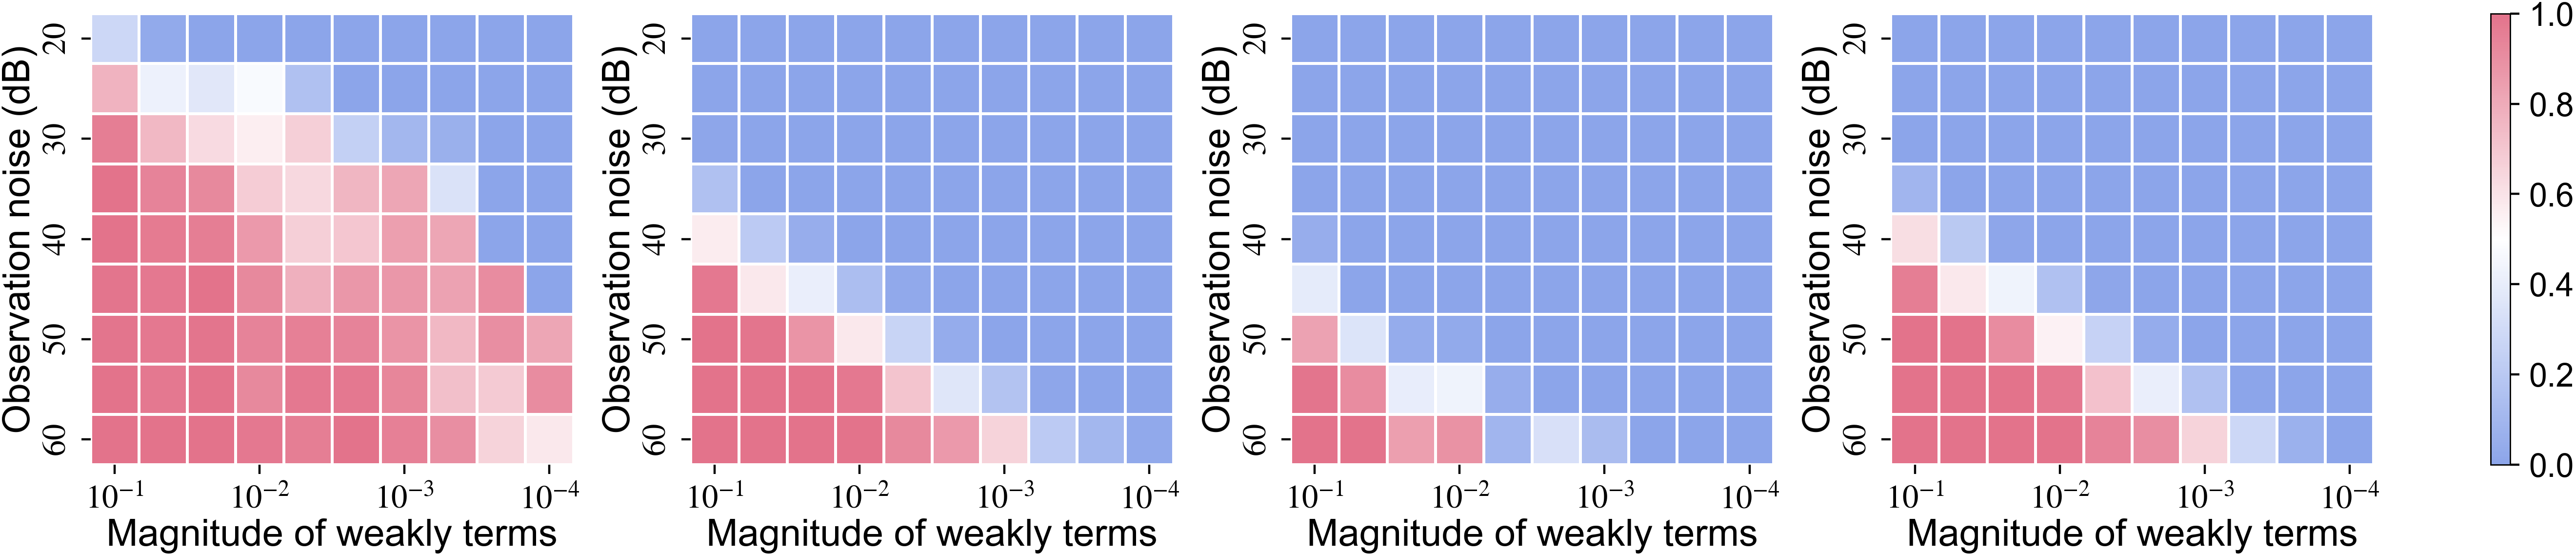

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
titles = ["Our","SINDy-STLSQ","SINDy-SR3","ENS-SINDy"]
fig,axes = plt.subplots(ncols=len(models)+1,figsize = (16,3),gridspec_kw=dict(width_ratios=[1,1,1,1,0.04]))
plt.subplots_adjust(wspace = 0.3)
for i in range(len(models)):
    ax = axes[i]
    sns.heatmap(result_fr[i], ax = ax,linewidth=1,vmin = 0,vmax = 1,cmap=cmap, cbar=False,alpha = 1)
    ax.set_xticks([0.5,3.5,6.5,9.5])
    ax.set_xticklabels(["$10^{-1}$","$10^{-2}$","$10^{-3}$","$10^{-4}$"],fontsize = 12)
    ax.set_yticks([0.5,2.5,4.5,6.5,8.5])
    ax.set_yticklabels(['$20$','$30$','$40$','$50$','$60$'],fontsize = 12)
    ax.set_xlabel("Magnitude of weakly terms",fontsize = 14)
    ax.set_ylabel("Observation noise (dB)",fontsize = 14)
    # ax.set_title(titles[i],fontsize = 18)
cbar = fig.colorbar(axes[0].collections[0], cax=axes[-1])
cbar.ax.tick_params(labelsize=12) 
plt.savefig("Fig/succuessful_ratio.svg",dpi = 300,transparent = True,bbox_inches="tight")
plt.savefig("Fig/succuessful_ratio.pdf",dpi = 300,transparent = True,bbox_inches="tight")